# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC209B Data Science 2: Advanced Topics in Data Science 

##  Final Project: Machine Learning for Medical Diagnosis


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman<br/>
**Authors**: Bennett Hellman, Jeffrey Mayolo, and Joseph Zuccarelli

<hr style="height:2pt">

---



<hr style="height:2pt">

<a id="contents"></a>

## Table of Contents 

- [**Introduction**](#intro)

- [**Exploratory Data Analysis**](#eda)

- [**Modeling**](#model)

- [**Results**](#results)

- [**Discussion**](#discussion)

- [**References**](#ref)

<a id="intro"></a>

# Introduction

Given the rise of big data, machine learning is currently being applied to inform decision making across various fields of study, one of them being healthcare. There are numerous applications of machine learning within the medical field that can be used to drastically improve patient care and outcomes. For instance, researchers are continuing to develop classifiers for the detection and/or diagnosis of disease. These classifiers have ranged anywhere from decision tree models trained on basic patient vitals all the way to convolutional neural networks (CNNs) trained on large quantities of high resolution X-ray images [1]. In the following paper we accomplish the latter, **as we demonstrate how to build a chest X-ray pathology classification system using transfer learning on a real-world X-ray dataset.**

<a id="eda"></a>

# Exploratory Data Analysis

The full dataset under analysis in this study contains 112,120 frontal-view X-rays of 32,717 unique patients [2]. Each observation in the dataset includes a patient ID, a follow up number, an X-ray image, various characteristics of the image, patient demographic information (i.e., age and gender), and a diagnosis label. In this study, individuals' X-ray images will serve as our predictor, while the diagnosis label will serve as our outcome of interest. 

Note that due to the massive size of the full dataset, we choose to select only the first 15000 images for use in carrying out our exploratory data analysis and modeling. Although ideally we would conduct our analysis on the entire dataset, this is not feasible due to limited computational power and project time constraints.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import PIL
import sys
import operator
import tensorflow as tf
import tensorflow.keras.backend as J
from skimage.io import imread_collection
from skimage.io import concatenate_images
from tqdm import tqdm
from time import time
from PIL import Image
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from google.colab import drive

In [2]:
# Mount drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Read in files from drive

# Define path 
col_dir = 'gdrive/MyDrive/209_project/images/*.png'

# Creating a collection with the available images
col = imread_collection(col_dir)

# Read labels csv (select 15000 images)
labels_df = pd.read_csv('gdrive/MyDrive/209_project/Data_Entry_2017_v2020.csv')
labels_df = labels_df.iloc[0:15000,:]

# Read in train test split
with open('gdrive/MyDrive/209_project/test_list.txt') as f:
    test_set = f.readlines()
    
# Read in train test split
with open('gdrive/MyDrive/209_project/train_val_list.txt') as f:
    train_val_set = f.readlines()

In [ ]:
# Display first 5 obs in dataset
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [ ]:
# Print dimensions
num_obs = labels_df.shape[0]
num_features = labels_df.shape[1]
print(f'Number of observations: {num_obs}')
print(f'Number of features: {num_features}')

Number of observations: 15000
Number of features: 11


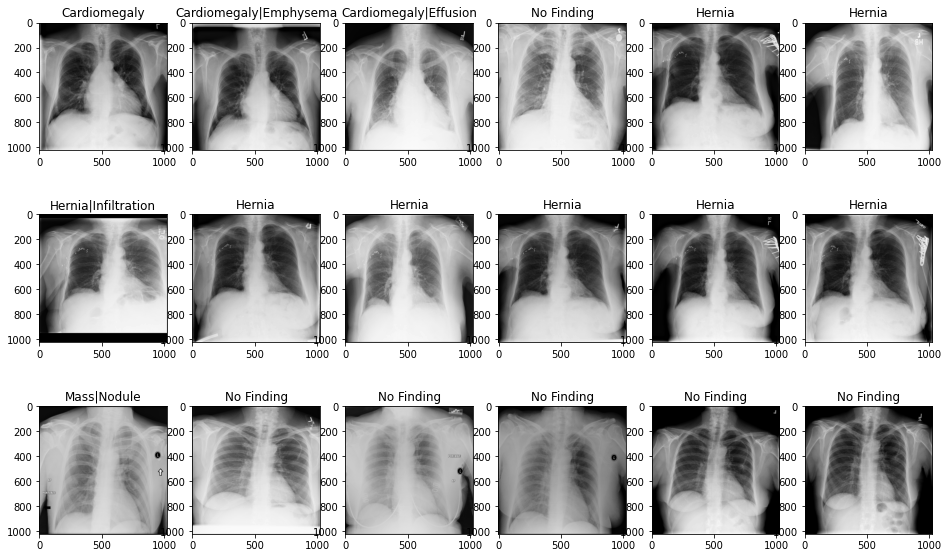

In [ ]:
# Plot sample X-ray images from dataset w/labels
fig, axes = plt.subplots(3,6, figsize = (16,10))
ax = axes.flatten()
for i in range(18):
    imgplot = ax[i].imshow(col[i], cmap = 'gray')
    ax[i].set_title(labels_df['Finding Labels'][i])
plt.show()

Here we explore our predictor, the X-ray images. Note that in the original dataset these images are 1024 by 1024 pixels; however, during the model training phase we plan to downsize the images for ease of computation. The grid of plots included above displays 18 sample images with diagnosis labels.

In [ ]:
# Explore response variable
print("Example Findings Labels")
print("------------------------")
print(np.unique(labels_df["Finding Labels"].values)[0:10])
label_count = labels_df["Finding Labels"].value_counts().count()
print(f"Number of unique labels: {label_count}")

Example Findings Labels
------------------------
['Atelectasis' 'Atelectasis|Cardiomegaly'
 'Atelectasis|Cardiomegaly|Consolidation'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Mass'
 'Atelectasis|Cardiomegaly|Edema|Effusion|Infiltration|Pneumothorax'
 'Atelectasis|Cardiomegaly|Effusion'
 'Atelectasis|Cardiomegaly|Effusion|Infiltration'
 'Atelectasis|Cardiomegaly|Effusion|Mass'
 'Atelectasis|Cardiomegaly|Effusion|Pneumonia']
Number of unique labels: 326


In [6]:
# One hot encode response
dis = ['Infiltration','Atelectasis','Effusion', 'Nodule', 'Mass', 'Consolidation', 'Cardiomegaly', 'Emphysema']
main = pd.concat([labels_df,pd.DataFrame(columns=dis)]).fillna(0)
samp = main['Finding Labels'].str.split('|').apply(lambda x : [i for i in dis if i in x])
for i,j in enumerate(samp):
    for k in j:
        main.loc[i,k] = 1 
main.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Infiltration,Atelectasis,Effusion,Nodule,Mass,Consolidation,Cardiomegaly,Emphysema
0,00000001_000.png,Cardiomegaly,0.0,1.0,57.0,M,PA,2682.0,2749.0,0.143,0.143,0,0,0,0,0,0,1,0
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,0.143,0,0,0,0,0,0,1,1
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,0.168,0,0,1,0,0,0,1,0
3,00000002_000.png,No Finding,0.0,2.0,80.0,M,PA,2500.0,2048.0,0.171,0.171,0,0,0,0,0,0,0,0
4,00000003_001.png,Hernia,0.0,3.0,74.0,F,PA,2500.0,2048.0,0.168,0.168,0,0,0,0,0,0,0,0


In [7]:
# One hot encode the rest of the labels
results = set()
labels_df['Finding Labels'].str.lower().str.split('|').apply(results.update)
print("Unique Findings Labels")
print(results)
diag = list(results)
main = pd.concat([labels_df,pd.DataFrame(columns=diag)]).fillna(0)
samp = main['Finding Labels'].str.lower().str.split('|').apply(lambda x : [i for i in diag if i in x])
for i,j in enumerate(samp):
    for k in j:
        main.loc[i,k] = 1 
main.head()

Unique Findings Labels
{'atelectasis', 'pleural_thickening', 'effusion', 'mass', 'infiltration', 'emphysema', 'hernia', 'fibrosis', 'consolidation', 'no finding', 'pneumonia', 'edema', 'nodule', 'cardiomegaly', 'pneumothorax'}


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema,hernia,fibrosis,consolidation,no finding,pneumonia,edema,nodule,cardiomegaly,pneumothorax
0,00000001_000.png,Cardiomegaly,0.0,1.0,57.0,M,PA,2682.0,2749.0,0.143,...,0,0,0,0,0,0,0,0,1,0
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,...,1,0,0,0,0,0,0,0,1,0
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,...,0,0,0,0,0,0,0,0,1,0
3,00000002_000.png,No Finding,0.0,2.0,80.0,M,PA,2500.0,2048.0,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_001.png,Hernia,0.0,3.0,74.0,F,PA,2500.0,2048.0,0.168,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Display updated columns
main.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'mass', 'edema',
       'pleural_thickening', 'hernia', 'cardiomegaly', 'pneumothorax',
       'effusion', 'atelectasis', 'pneumonia', 'nodule', 'fibrosis',
       'infiltration', 'consolidation', 'emphysema', 'no finding'],
      dtype='object')

In [ ]:
# Define dict with labels and their proportions
mean_y = {}
for i in diag:
  mean_y[i] = main[i].mean()

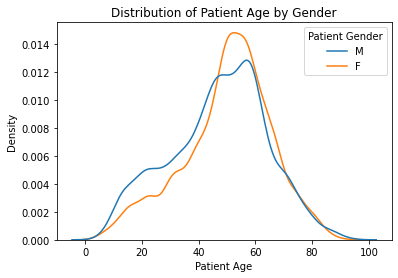

In [ ]:
# Plot: Distribution of Patient Age by Gender
sns.kdeplot(data=main, x="Patient Age", hue="Patient Gender")
plt.title("Distribution of Patient Age by Gender")
plt.show()

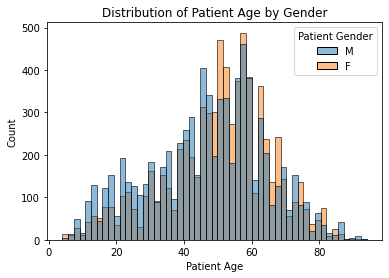

In [ ]:
# Plot: Distribution of Patient Age by Gender
sns.histplot(data=main, x="Patient Age", hue="Patient Gender")
plt.title("Distribution of Patient Age by Gender")
plt.show()

Here we explore the demographic characteristics of our patients--age and gender. The two plots included above display the distributions of males versus females by age. Note that the density of males in the dataset appears to be larger than the density of females up until about age 45, at which point the dataset appears to be dominated by females. Also note that the highest density of patients (males and females) lies somewhere between 50-60 years old.

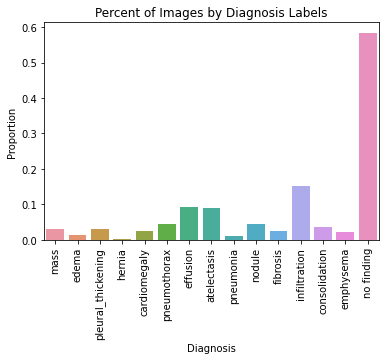

In [ ]:
# Plot: Percent of images by Diagnosis Labels
x = list(mean_y.keys())
y = list(mean_y.values())
ax = sns.barplot(x=x,y=y)
ax.set(xlabel='Diagnosis', ylabel='Proportion', title ='Percent of Images by Diagnosis Labels')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

Here we explore our outcome variable, the diagnosis label. Note that there are 836 distinct diagnosis labels. However, this arises from the permutation of 15 distinct diagnoses: mass, fibrosis, consolidation,pleural thickening, infiltration, cardiomegaly, emphysema, effusion, no finding, atelectasis, pneumothorax, nodule, edema, hernia, and pneumonia. Thus, we extract each label and generate 15 binary outcomes variables. The proportion of each outcome label included in the dataset is displayed in the plot included above. Note that over half of the images are labeled as no finding. The most prevalent disease appears to be infiltration, as approximately one-fifth of the X-ray images receive this label. This dataset clearly suffers from class imbalance, which we must account for when building our classifier model.

<a id="model"></a>

# Modeling 

As we discovered in the previous section, this dataset suffers from major class imbalance. This is an issue because most machine learning models perform best when the number of samples in each class is approximately equal. There are a few different techniques for dealing with unbalanced datasets. One technique is over-sampling, which involves duplicating random observations from the minority classes to bring the number of observations within these classes up to par with the majority class. Another technique is under-sampling, which involves removing random observations from the majority class to bring the number of observations within this class down to the level of the minority classes. Beyond using re-sampling techniques, another method to combat class imbalance is the use of a weighted-loss function. The idea is to weigh the loss computed for each observation differently based on whether it belongs to the majority or the minority classes. Essentially, the goal is to assign a higher weight to the loss encountered by the observations from the minority classes. In order to account for this phenomenon in the development of our models, we define and make use of a weighted loss function.

Another important aspect of training CNNs is data augmentation, a technique used to artificially create new training data from existing training data. This technique leads to the formation of new and slightly different images, creating a more rich and sufficient training dataset. There are various different methods of data augmentation that can increase the performance of CNN models: adding noise, rotation, translation, flipping, contrast, etc. We use a few of these methods to create variations of the X-ray images prior to training our models [3].

As mentioned in the introduction, the main goal of this project is to demonstrate how to build a chest X-ray pathology classification system using transfer learning on a real-world X-ray dataset. Recall that transfer learning is a machine learning method in which a pre-trained model is re-used as the starting point for a model on a new task. In the following section, we re-use three popular CNN model architectures to create our chest X-ray classification system: DenseNet121, DenseNet169, EfficientNet-B0.  

DenseNet is a type of CNN architecture where each layer is connected to all other layers that are deeper in the network (i.e., the first layer is connected to the 2nd, 3rd, 4th and so on, the second layer is connected to the 3rd, 4th, 5th and so on). This is done to enable maximum information flow between the layers of the network. In order to preserve the feed-forward nature of the network, each layer obtains inputs from all the previous layers and passes on its own feature maps to all the layers which will come after it. Ultimately, the design of DenseNet is intended to improve the declined accuracy caused by the vanishing gradient problem encountered in high-level neural networks. The image included below displays a sample DenseNet architecture [4,5].

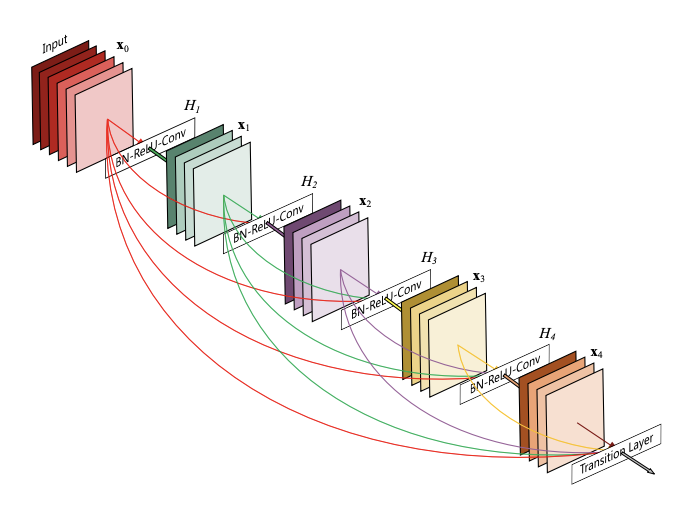

EfficientNets are a family of models developed using a simple yet highly effective compound coefficient to scale up CNNs in a more principled manner. These models are known for their ability to achieve high accuracy in an efficient manner, as they tend to utilize less parameters than existing CNN architectures. Given this information, EfficientNets are well suited for this project due to the time constraints and massive size of the dataset. The image included below displays the architecture of EfficientNet-B0 [6,7].

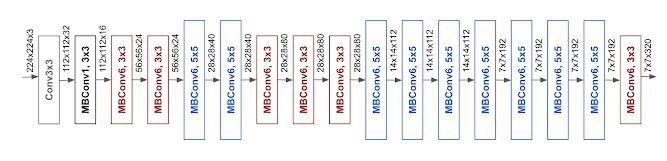

**In compliance with the AC209B requirement for this project, we implement the following technique that we did not discuss in class--deep steganography.** We will discuss this topic more in the following sections [8]. 

In this section, we complete the following tasks. First, we split the full dataset into three subsets: training dataset, validation dataset, and test dataset. Note that we perform this split in a manner that ensures each patient only appears once in each of these three datasets. This is a necessary step to prevent data leakage. Next, we implement functions to create data generators for each dataset, enabling for real-time data feeding to our models opposed to loading each entire dataset all at once. Finally, we build several different model architectures and train each model to properly classify each disease. Specifically, we experimented with three different model architechtures using pretrained weights: Densenet121, Densenet169,  and EfficientNet-B0.

### Models not included

As discussed earlier, there are several methods to combat class imbalance such as over-sampling, under-sampling, and weighted loss functions. In the development of this project, we implemented all three of these techniques. However, the results we achieved from the use of a weighted loss function outperformed that of over-sampling and under-sampling. In the interest of not making this notebook excessively long, we did not include our experimentation with sampling techniques and only applied weighted loss to each of the network types. Additionally, we also developed a CNN architecture from scratch. This network also performed poorly and was excluded from the final report.

### Preprocessing

In [27]:
# Create compact df for modeling purposes
compact_df = main.iloc[0:4999,:]
compact_df = compact_df.rename(columns={"Image Index": "Image"})
compact_df.columns

Index(['Image', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'atelectasis',
       'pleural_thickening', 'effusion', 'mass', 'infiltration', 'emphysema',
       'hernia', 'fibrosis', 'consolidation', 'no finding', 'pneumonia',
       'edema', 'nodule', 'cardiomegaly', 'pneumothorax'],
      dtype='object')

In [28]:
# Print dimensions of compact df
num_obs = compact_df.shape[0]
num_features = compact_df.shape[1]
print(f'Number of observations: {num_obs}')
print(f'Number of features: {num_features}')

Number of observations: 4999
Number of features: 26


In [29]:
# Print number of patients
num_patients = len(np.unique(compact_df['Patient ID']))
print(f"Number of unique patients: {num_patients}")

Number of unique patients: 1335


In [30]:
# Train/Test split to prevent data leakage
splitter1 = GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 209)
split1 = splitter1.split(compact_df, groups=compact_df['Patient ID'])
train1_idxs, test_idxs = next(split1)
train1_df = compact_df.iloc[train1_idxs]
test_df = compact_df.iloc[test_idxs]

# Train/Val split to prevent data leakage
splitter2 = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 209)
split2 = splitter2.split(train1_df, groups=train1_df['Patient ID'])
train2_idxs, val_idxs = next(split2)
train_df = train1_df.iloc[train2_idxs]
val_df = train1_df.iloc[val_idxs]

In [31]:
# Test to ensure no data leakage
patientID_list = list(compact_df['Patient ID'].unique())
train_vals = train_df['Patient ID'].unique()
val_vals = val_df['Patient ID'].unique()
test_vals = test_df['Patient ID'].unique()
for id in patientID_list:
    assert 1 == int(id in train_vals) + int(id in val_vals) +  int(id in test_vals)

In [32]:
# Print dimensions
print("Observations by Split")
print("---------------------")
print(f"Number of training obs: {train_df.shape[0]}")
print(f"Number of validation obs: {val_df.shape[0]}")
print(f"Number of test obs: {test_df.shape[0]}")

Observations by Split
---------------------
Number of training obs: 3361
Number of validation obs: 822
Number of test obs: 816


In [19]:
# Define findings labels of interests
labels = ['cardiomegaly', 'emphysema','hernia',
          'infiltration', 'mass', 'nodule',
          'atelectasis','pneumothorax','pleural_thickening',
          'pneumonia','fibrosis','edema','consolidation']

In [15]:
# Define function to build training dataset generator
def get_train_generator(df, image_dir, x_col, y_col, shuffle = True, batch_size=8,seed=1,target_w=320,target_h=320):

  # Create image generator image to generate the images
  image_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

  # Generate the images and labels using tf's 'flow_from_dataframe'
  generator = image_generator.flow_from_dataframe(dataframe=df,directory=image_dir, x_col=x_col,y_col=y_col,class_mode='raw',
                                                  batch_size = batch_size,shuffle=shuffle,seed=seed, target_size=(target_w,target_h))
  
  return generator 

In [16]:
# Define function to build validation/test dataset generator
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size = 100, batch_size = 8, seed = 1, target_w = 320, target_h = 320):
  
  # Greate image generator from train set
  raw_train_generator = ImageDataGenerator().flow_from_dataframe(dataframe = train_df,directory = IMAGE_DIR, x_col = 'Image',
                                                                 y_col = labels, class_mode = 'raw', batch_size = sample_size, shuffle = True,
                                                                 target_size = (target_w, target_h))
  batch = raw_train_generator.next()
  data_sample = batch[0]
  image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
  image_generator.fit(data_sample)

  # Create image generator from validation dataframe
  valid_generator = ImageDataGenerator().flow_from_dataframe(dataframe = valid_df,directory = image_dir, x_col = x_col,
                                                                 y_col = y_cols, class_mode = 'raw', batch_size = sample_size, shuffle = False,
                                                                 target_size = (target_w, target_h))
  
  #Create image generator from test set
  test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = test_df,directory = image_dir, x_col = x_col,
                                                                 y_col = y_cols, class_mode = 'raw', batch_size = sample_size, shuffle = False,
                                                                 target_size = (target_w, target_h))
  
  return valid_generator, test_generator

In [17]:
# Define function that returns a weighted loss function (class imbalance)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
  def weighted_loss(y_true, y_pred):
    loss = 0
    try:
      for i in range(len(pos_weights)):
        loss += -1. * J.mean(pos_weights[i]*y_true[:,i]*J.log(y_pred[:,i] + epsilon) + neg_weights[i]*(1-y_true[:,i]) * J.log(1 - y_pred[:,i] + epsilon))
    except:
      loss += -1. * J.mean(pos_weights*y_true[:]*J.log(y_pred[:] + epsilon) + neg_weights*(1-y_true[:]) * J.log(1 - y_pred[:] + epsilon))
    return loss
  return weighted_loss

### Model 0: DenseNet121 (Multi-class Classification)

In [ ]:
# Define proper image directory
IMAGE_DIR = 'gdrive/MyDrive/209_project/images'

# Define features to predict
feat_to_predict = ['infiltration', 'effusion', 'atelectasis', 'mass','nodule']

# Define train/validation/test generators
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", feat_to_predict)
valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image", feat_to_predict)

Found 3361 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.


In [ ]:
# Define class weights
pos_weights = []
neg_weights = []
for j in range(len(feat_to_predict)):
  pos_weights.append(np.sum(train_generator.labels[:,j]==1)/len(train_generator.labels[:,j]))
  neg_weights.append(1-pos_weights[j])

In [ ]:
# DenseNet121 from module A section
tf.compat.v1.disable_eager_execution()

base_model = DenseNet121(weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(len(feat_to_predict), activation = 'softmax')(x)

model0 = Model(inputs = base_model.input, outputs = predictions)
model0.compile(optimizer = 'adam', loss = get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Fit model
history0 = model0.fit(train_generator, validation_data = valid_generator, epochs = 5, verbose = 1)

Epoch 1/5
421/421 [==============================] - ETA: 0s - batch: 210.0000 - size: 7.9834 - loss: 0.9919

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


421/421 [==============================] - 222s 413ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.9919 - val_loss: 5.4229
Epoch 2/5
421/421 [==============================] - 167s 396ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.9905 - val_loss: 14.0755
Epoch 3/5
421/421 [==============================] - 175s 414ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.9887 - val_loss: 14.0755
Epoch 4/5
421/421 [==============================] - 184s 438ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.9832 - val_loss: 14.0755
Epoch 5/5
421/421 [==============================] - 168s 400ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.9797 - val_loss: 13.4258


In [ ]:
# Calculate model predictions
preds = model0.predict(valid_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Print F1 scores
for i in range(len(feat_to_predict)):
  fscore = f1_score(valid_generator.labels[:,i], np.around(preds[:,i]))
  print(f'Validation f1 score for {feat_to_predict[i]}: {fscore:.2f}')

Validation f1 score for infiltration: 0.00
Validation f1 score for effusion: 0.17
Validation f1 score for atelectasis: 0.00
Validation f1 score for mass: 0.00
Validation f1 score for nodule: 0.00


As indicated by the poor F1 scores, this multi-class model performs extremely poorly. Therefore, we will experiment with a few binary classifier models.

### Model 1: Densenet121 (Binary Classification)

In [ ]:
# Define proper image directory
IMAGE_DIR = 'gdrive/MyDrive/209_project/images'

# Define features to predict
feat_to_predict = ['infiltration']

# Define train/validation/test generators
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", feat_to_predict)
valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image", feat_to_predict)

In [ ]:
# Calculating positive and negative weights for weighted loss
pos_weights = np.sum(train_generator.labels==1)/len(train_generator.labels)
neg_weights = 1-pos_weights

In [ ]:
# MODEL 1: DenseNet121(ImageNet)
tf.compat.v1.disable_eager_execution()

base_model = DenseNet121(weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation = 'sigmoid')(x)

model1 = Model(inputs = base_model.input, outputs = predictions)
model1.compile(optimizer = 'adam', loss = get_weighted_loss(pos_weights, neg_weights), metrics = [tf.keras.metrics.Precision(name='precision')])
model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_16 (ZeroPadding  (None, None, None,   0          ['input_9[0][0]']                
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_16[0][0]']      
                                64)                                                         

In [ ]:
# Fit model
history1 = model1.fit(train_generator, validation_data= valid_generator, epochs = 5, verbose = 1)

Epoch 1/5
421/421 [==============================] - ETA: 0s - batch: 210.0000 - size: 7.9834 - loss: 0.1186 - precision: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


421/421 [==============================] - 218s 415ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.1186 - precision: 0.0000e+00 - val_loss: 0.1082 - val_precision: 0.0000e+00
Epoch 2/5
421/421 [==============================] - 156s 370ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.1136 - precision: 0.0000e+00 - val_loss: 1.0951 - val_precision: 0.1421
Epoch 3/5
421/421 [==============================] - 155s 369ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.1143 - precision: 0.0000e+00 - val_loss: 11.3550 - val_precision: 0.1509
Epoch 4/5
421/421 [==============================] - 156s 371ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.1137 - precision: 0.0000e+00 - val_loss: 11.3550 - val_precision: 0.1509
Epoch 5/5
421/421 [==============================] - 155s 368ms/step - batch: 210.0000 - size: 7.9834 - loss: 0.1167 - precision: 0.0000e+00 - val_loss: 11.3550 - val_precision: 0.1509


In [ ]:
# Get model predictions and store metrics
preds = model1.predict(valid_generator, steps = len(valid_generator))
fpr, tpr, thresholds = roc_curve(valid_generator.labels, preds)
auc = roc_auc_score(valid_generator.labels, preds)

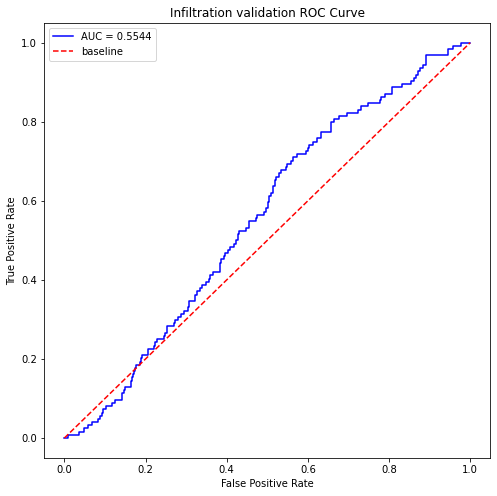

In [ ]:
# Plot: Infiltration validation ROC Curve
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, c = 'blue', label = ('AUC = ' + str(round(auc,4))))
plt.plot([0,1],[0,1], c='red', linestyle = '--', label = 'Baseline')
plt.title('Infiltration validation ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'best')
plt.show()

Based on this model's poor performance on the validation set, we decided to move on to another model architechture for tuning.

### Model 2: DenseNet169 (Binary Classification)

NOTE: For this model, we increased the data size to use the 10,000 images in the second folder rather than just the 5,000 images in the first folder.

In [8]:
# Create compact df for modeling purposes
compact_df_big = main.iloc[5000:15000,:]
compact_df_big = compact_df_big.rename(columns={"Image Index": "Image"})
compact_df_big.columns

Index(['Image', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'atelectasis',
       'pleural_thickening', 'effusion', 'mass', 'infiltration', 'emphysema',
       'hernia', 'fibrosis', 'consolidation', 'no finding', 'pneumonia',
       'edema', 'nodule', 'cardiomegaly', 'pneumothorax'],
      dtype='object')

In [9]:
# Print dimensions of compact df
num_obs = compact_df_big.shape[0]
num_features = compact_df_big.shape[1]
print(f'Number of observations: {num_obs}')
print(f'Number of features: {num_features}')

Number of observations: 10000
Number of features: 26


In [10]:
# Print number of patients
num_patients = len(np.unique(compact_df_big['Patient ID']))
print(f"Number of unique patients: {num_patients}")

Number of unique patients: 2587


In [11]:
# Train/Test split to prevent data leakage
splitter1 = GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 209)
split1 = splitter1.split(compact_df_big, groups=compact_df_big['Patient ID'])
train1_idxs, test_idxs = next(split1)
train1_df = compact_df_big.iloc[train1_idxs]
test_df_big = compact_df_big.iloc[test_idxs]

# Train/Val split to prevent data leakage
splitter2 = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 209)
split2 = splitter2.split(train1_df, groups=train1_df['Patient ID'])
train2_idxs, val_idxs = next(split2)
train_df_big = train1_df.iloc[train2_idxs]
val_df_big = train1_df.iloc[val_idxs]

In [12]:
# Test to ensure no data leakage
patientID_list = list(compact_df_big['Patient ID'].unique())
train_vals = train_df_big['Patient ID'].unique()
val_vals = val_df_big['Patient ID'].unique()
test_vals = test_df_big['Patient ID'].unique()
for id in patientID_list:
    assert 1 == int(id in train_vals) + int(id in val_vals) +  int(id in test_vals)

In [13]:
# Print dimensions
print("Observations by Split")
print("---------------------")
print(f"Number of training obs: {train_df_big.shape[0]}")
print(f"Number of validation obs: {val_df_big.shape[0]}")
print(f"Number of test obs: {test_df_big.shape[0]}")

Observations by Split
---------------------
Number of training obs: 6830
Number of validation obs: 1589
Number of test obs: 1581


In [20]:
# Define proper image directory
directory = 'gdrive/MyDrive/209_project/images_2'

# Define features to predict
feat_to_predict = ['infiltration']

# Define train/validation/test generators
train_generator = get_train_generator(train_df_big, directory, "Image", feat_to_predict)
valid_generator, test_generator = get_test_and_valid_generator(val_df_big, test_df_big, train_df_big, directory, "Image", feat_to_predict)

Found 6830 validated image filenames.
Found 6830 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1588 validated image filenames.
Found 1581 validated image filenames.


In [ ]:
# Add a bias initializer to ensure the model does not get stuck on a naive version
neg, pos = np.bincount(train_df_big['infiltration'])
bias_initializer2 = np.log([pos/neg])
bias_initializer2

array([-1.84503577])

In [ ]:
# Create model with pre-trained weights
import tensorflow.keras as K
densenet_model = K.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(320,320,3),
    pooling=None
)

# Make model trainable
densenet_model.trainable = True

#Build Architechture
for layer in densenet_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False
input = K.Input(shape=(320, 320, 3))
layer = densenet_model(inputs=input)
layer = K.layers.Flatten()(layer)
layer = K.layers.BatchNormalization()(layer)
initializer = K.initializers.he_normal(seed=69)
layer = K.layers.Dense(units=128,
                        activation='relu',
                        kernel_initializer=initializer
                        )(layer)

layer = K.layers.Dropout(0.4)(layer)
layer = K.layers.BatchNormalization()(layer)
layer = K.layers.Dense(units=128,
                       activation='relu',
                       kernel_initializer=initializer
                       )(layer)

layer = K.layers.Dropout(0.4)(layer)
layer = K.layers.Dense(units=1,
                       activation='sigmoid',
                       kernel_initializer=initializer,
                       bias_initializer = tf.keras.initializers.Constant(bias_initializer2)
                       )(layer)
model2 = K.models.Model(inputs=input, outputs=layer)


model2.summary()


model2.compile(loss='binary_crossentropy',
            optimizer=K.optimizers.Adam(lr = 0.0001),
            metrics = [K.metrics.Precision(name='precision'), K.metrics.AUC()])

51888128/51877672 [==============================] - 0s 0us/step
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 320, 320, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 10, 10, 1664)      12642880  
                                                                 
 flatten (Flatten)           (None, 166400)            0         
                                                                 
 batch_normalization (BatchN  (None, 166400)           665600    
 ormalization)                                                   
                                                                 
 dense_9 (Dense)             (None, 128)               21299328  
                                                                 
 dropout (Dropout)           (None, 128)               0    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Define class weights for weighted loss
weight_for_0 = neg_weights * (len(train_generator.labels) / 1.0)
weight_for_1 = pos_weights * (len(train_generator.labels) / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
# Save best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='gdrive/MyDrive/209_project/val_precision',
    save_weights_only=False,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

In [ ]:
# Fit the model
history2 = model2.fit(train_generator, validation_data = valid_generator, epochs = 10, verbose = 1, class_weight = class_weight, callbacks=[model_checkpoint_callback])

In [21]:
# Save models
mod_169 = tf.keras.models.load_model('gdrive/MyDrive/209_project/val_precision')

In [ ]:
# Getting predictions from saved model
preds = mod_169.predict(valid_generator, steps = len(valid_generator))
fpr, tpr, thresholds = roc_curve(valid_generator.labels, preds)
auc = roc_auc_score(valid_generator.labels, preds)

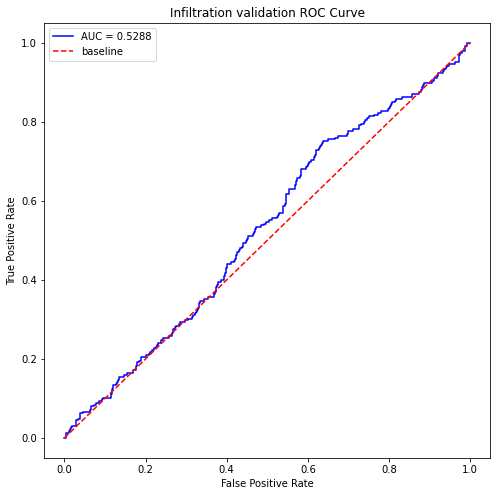

In [ ]:
# Plot: Infiltration validation ROC Curve
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, c = 'blue', label = ('AUC = ' + str(round(auc,4))))
plt.plot([0,1],[0,1], c='red', linestyle = '--', label = 'Baseline')
plt.title('Infiltration validation ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'best')
plt.show()

Once again, this model performs poorly, as indicated by the AUC score below 0.5. Let's experiment with another new model architecture.

### Model 3: EfficientNet-B0

In [33]:
# Define proper image directory
IMAGE_DIR = 'gdrive/MyDrive/209_project/images'

#Define features to predict
feat_to_predict = ['infiltration']

# Define train/validation/test generators
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", feat_to_predict)
valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image", feat_to_predict)

Found 3361 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.


In [ ]:
# Define image size
IMG_SIZE = 320

# Import dependencies
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Agument the images
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
# Define function to build model
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)
    model3.compile(
        optimizer=optimizer, loss="bce", metrics=["accuracy"]
    )
    return model

In [ ]:
# Build model
model3 = build_model(num_classes=1)

In [ ]:
# Implement checkpoints
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='gdrive/MyDrive/209_project/bare_auc',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Fit model
history3 = model3.fit(train_generator, epochs=20, validation_data=valid_generator, class_weight=class_weights, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/20
421/421 [==============================] - 84s 199ms/step - loss: 1.0788 - accuracy: 0.5004 - val_loss: 2.2319 - val_accuracy: 0.7032
Epoch 2/20
421/421 [==============================] - 81s 192ms/step - loss: 1.4904 - accuracy: 0.4820 - val_loss: 8.2988 - val_accuracy: 0.2920
Epoch 3/20
421/421 [==============================] - 80s 189ms/step - loss: 1.3105 - accuracy: 0.5076 - val_loss: 11.9506 - val_accuracy: 0.3078
Epoch 4/20
421/421 [==============================] - 80s 190ms/step - loss: 1.0571 - accuracy: 0.4802 - val_loss: 14.7027 - val_accuracy: 0.1509
Epoch 5/20
421/421 [==============================] - 80s 189ms/step - loss: 1.3159 - accuracy: 0.4880 - val_loss: 8.2615 - val_accuracy: 0.3212
Epoch 6/20
421/421 [==============================] - 81s 192ms/step - loss: 1.5921 - accuracy: 0.5192 - val_loss: 5.1613 - val_accuracy: 0.8491
Epoch 7/20
421/421 [==============================] - 79s 188ms/step - loss: 1.2324 - accuracy: 0.4832 - val_loss: 2.9784 - val_

In [ ]:
# Save models
model3.save('gdrive/MyDrive/209_project/bare_auc3')

INFO:tensorflow:Assets written to: gdrive/MyDrive/209_project/bare_auc3/assets


In [ ]:
# Load saved models
model3 = tf.keras.models.load_model('gdrive/MyDrive/209_project/bare_auc3')

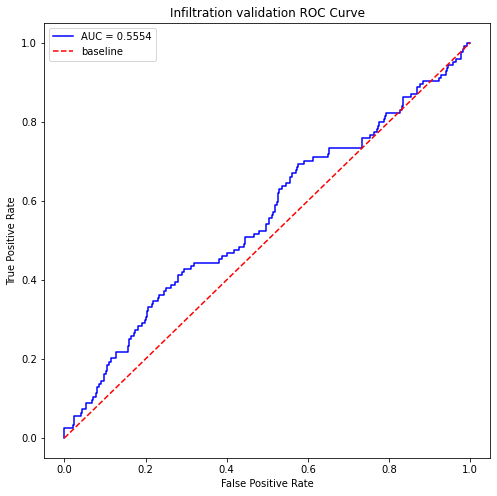

In [ ]:
# Getting predictions from saved model
preds = model3.predict(valid_generator, steps = len(valid_generator))
fpr, tpr, thresholds = roc_curve(valid_generator.labels, preds)
auc = roc_auc_score(valid_generator.labels, preds)

# Plot: Infiltration validation ROC Curve
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, c = 'blue', label = ('AUC = ' + str(round(auc,4))))
plt.plot([0,1],[0,1], c='red', linestyle = '--', label = 'Baseline')
plt.title('Infiltration validation ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'best')
plt.show()

As this model architechture performs the best on the validation set we selected this model as our best performing and will continue to fine-tune it and eventually evaluate it on the test set.

In [ ]:
#################
###############
#Pipeline
###############
###############

In [ ]:
labels = ['cardiomegaly', 'emphysema','hernia',
          'infiltration', 'mass', 'nodule',
          'atelectasis','pneumothorax','pleural_thickening',
          'pneumonia','fibrosis','edema','consolidation']
for i in range(len(labels)):
  print(labels[i])

cardiomegaly
emphysema
hernia
infiltration
mass
nodule
atelectasis
pneumothorax
pleural_thickening
pneumonia
fibrosis
edema
consolidation


In [ ]:
# Loop through all labels and create a wull-tuned classification network for it

for i in range(len(labels)):
  train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", str(labels[i]))
  valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image", str(labels[i]))
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='gdrive/MyDrive/209_project/'+ str(labels[i])+'weights',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
  class_weights = compute_class_weight(
                                          class_weight = "balanced",
                                          classes = np.unique(train_generator.labels),
                                          y = train_generator.labels                                                    
                                      )
  class_weights = dict(zip(np.unique(train_generator.labels), class_weights))
  hist = model3.fit(train_generator, epochs=30, validation_data=valid_generator, class_weight=class_weights, verbose=1, callbacks=[model_checkpoint_callback])
  model3.save('gdrive/MyDrive/209_project/'+str(labels[i]))

Getting train generator...
Found 3361 validated image filenames.
Getting test/validation generator...
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Epoch 1/30
421/421 [==============================] - 121s 288ms/step - loss: 4.0608 - accuracy: 0.5394 - val_loss: 4.3169 - val_accuracy: 0.8443
Epoch 2/30
421/421 [==============================] - 120s 286ms/step - loss: 4.6509 - accuracy: 0.5364 - val_loss: 2.6758 - val_accuracy: 0.9513
Epoch 3/30
421/421 [==============================] - 80s 191ms/step - loss: 6.5777 - accuracy: 0.5415 - val_loss: 149.3462 - val_accuracy: 0.0389
Epoch 4/30
421/421 [==============================] - 120s 285ms/step - loss: 6.9896 - accuracy: 0.5204 - val_loss: 7.1944 - val_accuracy: 0.9684
Epoch 5/30
421/421 [==============================] - 83s 196ms/step - loss: 4.3186 - accuracy: 0.5115 - val_loss: 107.0470 - val_accuracy: 0.0620
Epoch 6/30
421/421 [==============================] - 

This loop created a separate EfficientNet-B0 to predict each of the binary responses. The model architecture and weights were then saved to a Google drive so that they can be used on the test set to evaluate performance. This evaluation is done in the results section.

### Model 4: Deep Steganography

Steganography is the idea of hiding images in plain sight. The topic differentiates itself from encryption by aiming to make the message undetectable in transmission. Ideally, the only way to know a message exists is to hold some sort of revealing key. 

Neural networks act as this revealing key for steganography. You can imagine the parallels with an autoencoder. One network acts as a lock to encode information. If this network is built in such a way that the encoded information is undetectable, it functions as a steganographic network. Then the message can only be detected and decrypted by a sister network functioning as the key. We aim to do this by concealing an image within another image using deep nets [8].

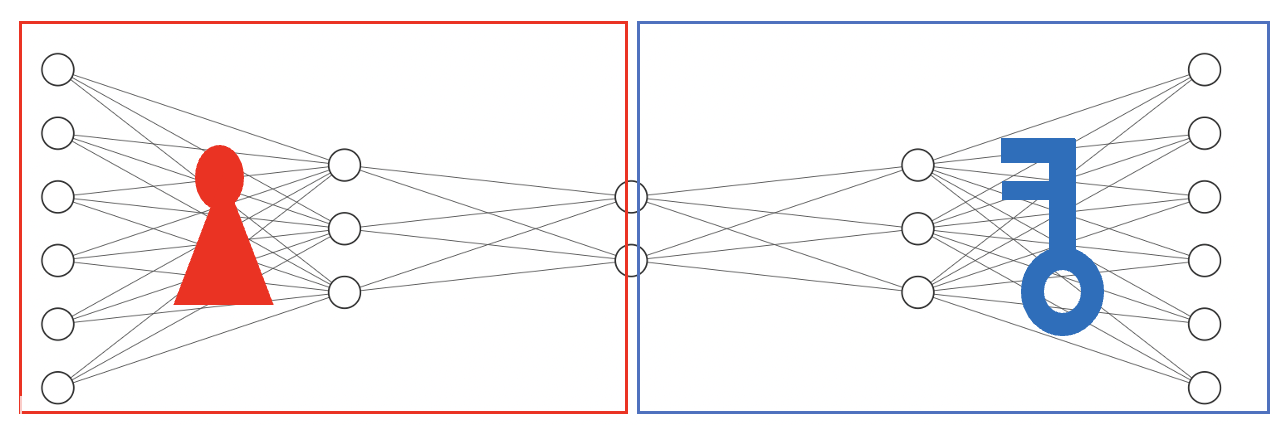

Naturally, this process relies on information encoding and compression. This is done by the illustrated modular network component which is utilized frequently throughout the process. It consists of iteratively taking an input, applying varying levels of encoding using convolution layers, and then concatenating them. In this way, each iteration actually creates more total information [8].

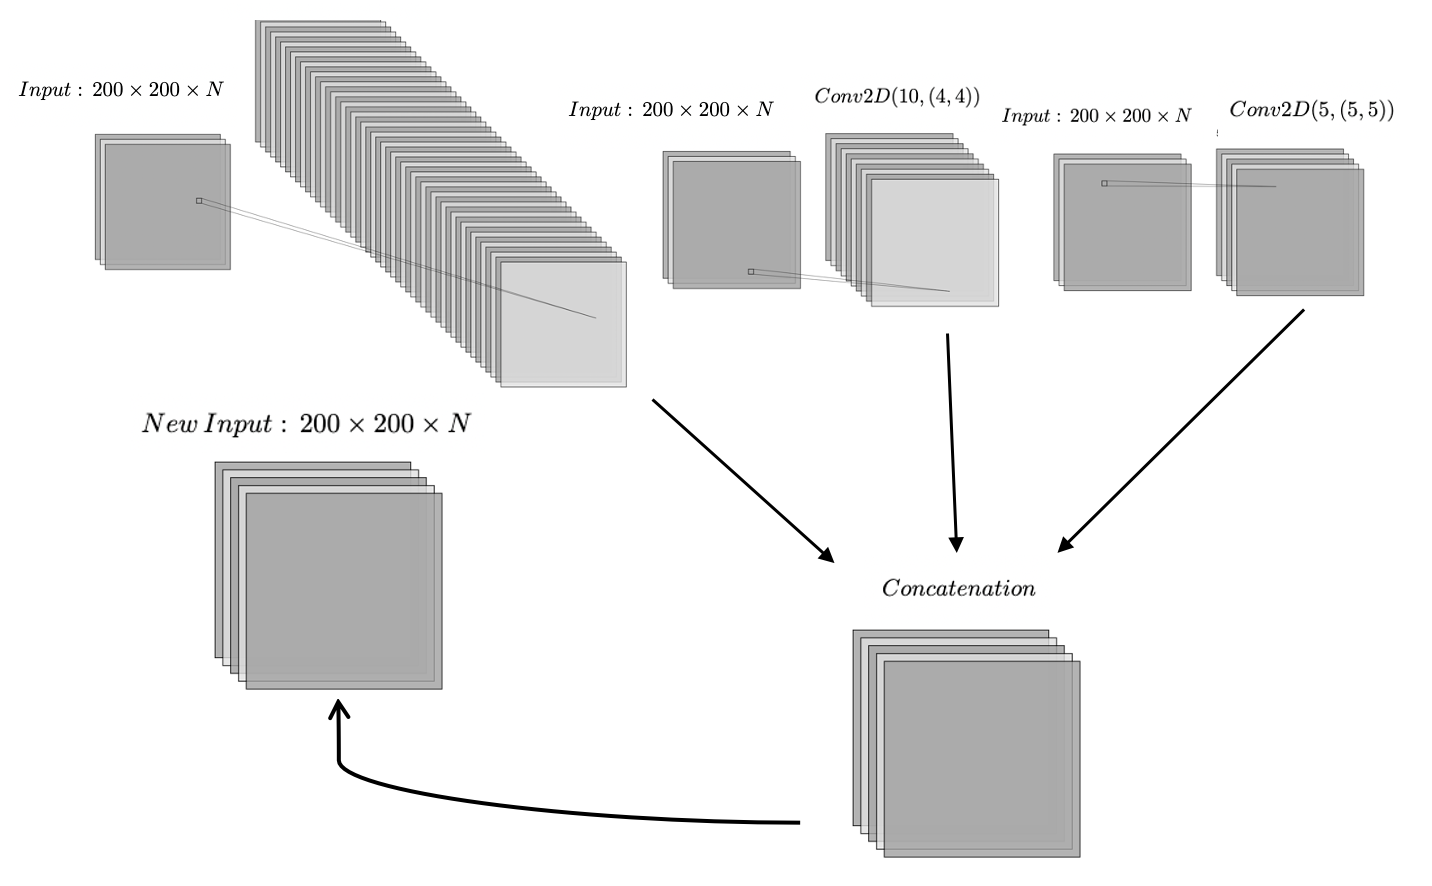

Our meta-network consists of three networks: a PrepNet, a HideNet and a RevealNet. The Prepnet is simply two iterations of the compression subnetwork which transforms the secret image by encoding it. This transformed image is then concatenated with the mask image and inputted into the Hidenet. The Hidenet iterates the compression subnetwork five times to create the hidden image. The hidden image is transmitted in plain sight to the RevealNet which uncovers the secret message [8].

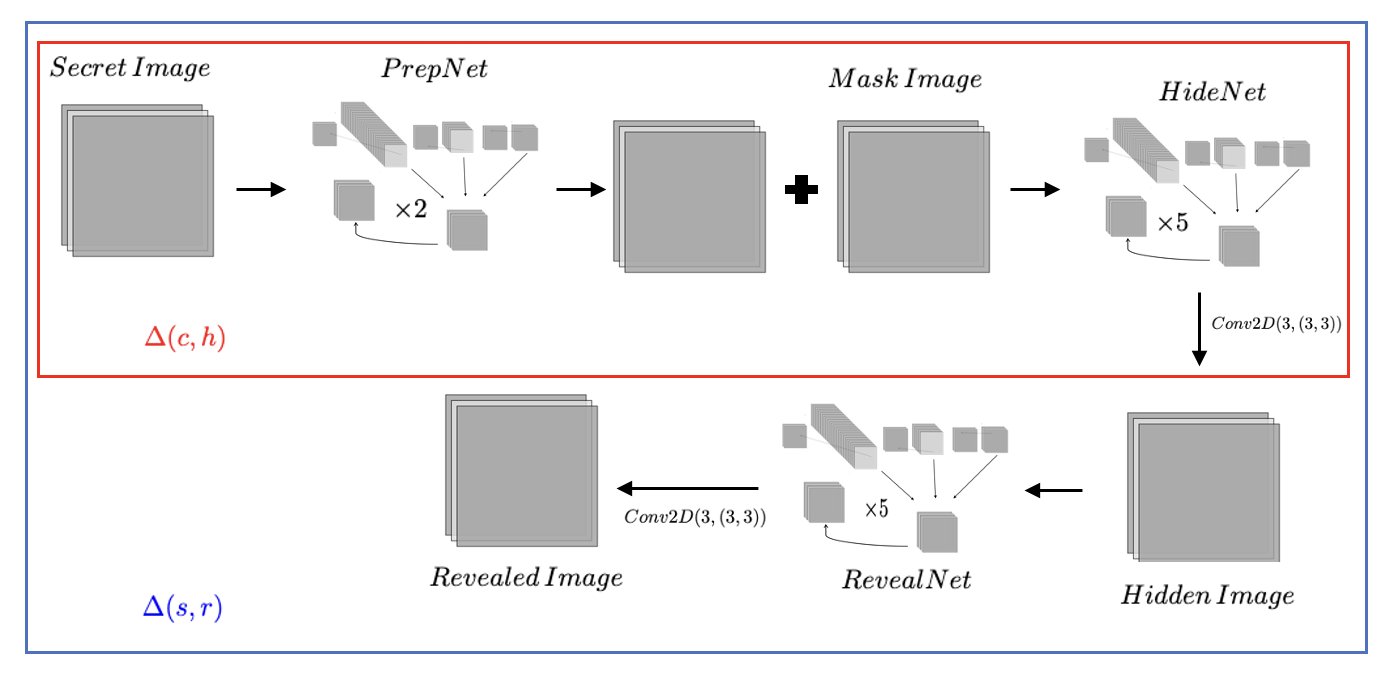

In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
#from keras.engine.network import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

import collections
import random

%matplotlib inline

In [ ]:
DATA_DIR = "gdrive/MyDrive/"
masks = os.path.join(DATA_DIR, "cv_project_images_masks")
secerets = 'gdrive/MyDrive/209_project/images/'


In [ ]:
num_images_test=300
secret_train = []
secret_test = []
list_of_imgs = []
c_dir = os.path.join(secrets)
# Create training set.
#for c in os.listdir(secrets):
c_imgs = os.listdir(c_dir)
for img_name_i in tqdm(c_imgs[0:300]):
    img_i = image.load_img(os.path.join(c_dir, img_name_i), target_size=(200,200))
    x = image.img_to_array(img_i)
    list_of_imgs.append(x)
for i in list_of_imgs[0:num_images_test]:
    secret_train.append(i)
for i in list_of_imgs[num_images_test:num_images_test*2]:
    secret_test.append(i)

100%|██████████| 300/300 [00:07<00:00, 37.81it/s]


In [ ]:
secret_train = np.array(secret_train)/255.
secret_test = np.array(secret_test)/255.

# Print statistics.
print ("Number of training examples = " + str(secret_train.shape[0]))
print ("Number of test examples = " + str(secret_train.shape[0]))
print ("X_train shape: " + str(secret_train.shape))
print ("X_test shape: " + str(secret_test.shape))

Number of training examples = 300
Number of test examples = 300
X_train shape: (300, 200, 200, 3)
X_test shape: (0,)


In [ ]:
num_images_test=300
mask_train = []
mask_test = []
list_of_imgs = []
# Create training set.
for c in os.listdir(masks):
    c_dir = os.path.join(masks, c)
    c_imgs = os.listdir(c_dir)
    for img_name_i in c_imgs:
        img_i = image.load_img(os.path.join(c_dir, img_name_i), target_size=(200,200))
        x = image.img_to_array(img_i)
        list_of_imgs.append(x)
for i in list_of_imgs[0:num_images_test]:
    mask_train.append(i)
for i in list_of_imgs[num_images_test:num_images_test*2]:
    mask_test.append(i)

In [ ]:
mask_train = np.array(mask_train)/255.
mask_test = np.array(mask_test)/255.

# Print statistics.
print ("Number of training examples = " + str(mask_train.shape[0]))
print ("Number of test examples = " + str(mask_train.shape[0]))
print ("X_train shape: " + str(mask_train.shape))
print ("X_test shape: " + str(mask_test.shape))

Number of training examples = 300
Number of test examples = 300
X_train shape: (300, 200, 200, 3)
X_test shape: (300, 200, 200, 3)


In [ ]:
input_S = secret_train[0:300]
input_C = mask_train[0:300]

In [ ]:
beta = 0.5
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true = y_true[...,0:3]
    c_true = y_true[...,3:6]
    s_pred = y_pred[...,0:3]
    c_pred = y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss

In [ ]:
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

In [ ]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
#    else:
#        return Container(inputs=reveal_input,
#                         outputs=output_Sprime,
#                         name = 'DecoderFixed')

In [ ]:
# Full model.
def make_model(input_size, loss_func=full_loss):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss= full_loss)
    
    return encoder, decoder, autoencoder

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
def training_func(loss_file_name, model_name, n_epochs=750):
    NB_EPOCHS = n_epochs
    BATCH_SIZE = 30

    m = input_S.shape[0]
    n = input_C.shape[0]
    loss_history = []
    for epoch in range(NB_EPOCHS):
        np.random.shuffle(input_S)
        np.random.shuffle(input_C)
        
        t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
        ae_loss = []
        rev_l = []
        for idx in t:
            
            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_C = input_C[idx:min(idx + BATCH_SIZE, n)]
            #batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            #batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]       
            C_prime = encoder_model.predict([batch_S, batch_C])
            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
            
            C_prime = encoder_model.predict([batch_S, batch_C])
            aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                      y=np.concatenate((batch_S, batch_C),axis=3))
            
            ae_loss.append(aeLoss)

            REVL = reveal_model.train_on_batch(x=C_prime,
                                                  y=batch_S)
            rev_l.append(REVL)
            # Update learning rate
            K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
            K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
            
            t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(REVL)))
        loss_history.append(np.mean(ae_loss))
    loss_history = [float(i) for i in loss_history]
    loss_history = np.array(loss_history)
    loss_history.tofile("gdrive/MyDrive/209_project/"+loss_file_name)
    autoencoder_model.save("gdrive/MyDrive/209_project/"+model_name+".h5")
    autoencoder_model.save_weights('gdrive/MyDrive/209_project/'+model_name+'.hdf5')


In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:], loss_func = full_loss)
training_func('loss', 'mod', n_epochs=100)

Epoch 1 | Batch: 270 of 300. Loss AE  978500.91 | Loss Rev  344123.56: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]
Epoch 2 | Batch: 270 of 300. Loss AE  369243.65 | Loss Rev  183667.81: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
Epoch 3 | Batch: 270 of 300. Loss AE  219268.88 | Loss Rev  115565.36: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
Epoch 4 | Batch: 270 of 300. Loss AE  181582.51 | Loss Rev   98997.32: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
Epoch 5 | Batch: 270 of 300. Loss AE  164217.39 | Loss Rev   96308.17: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
Epoch 6 | Batch: 270 of 300. Loss AE  118638.13 | Loss Rev   47475.59: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
Epoch 7 | Batch: 270 of 300. Loss AE  168416.88 | Loss Rev   51072.84: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
Epoch 8 | Batch: 270 of 300. Loss AE  120246.40 | Loss Rev   49972.83: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
Epoch 9 | Batch: 270 of 300. Loss AE   88366.13 

In [ ]:
autoencoder_model2 = make_model(input_S.shape[1:])[2]
autoencoder_model2.load_weights('gdrive/MyDrive/209_project/mod.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


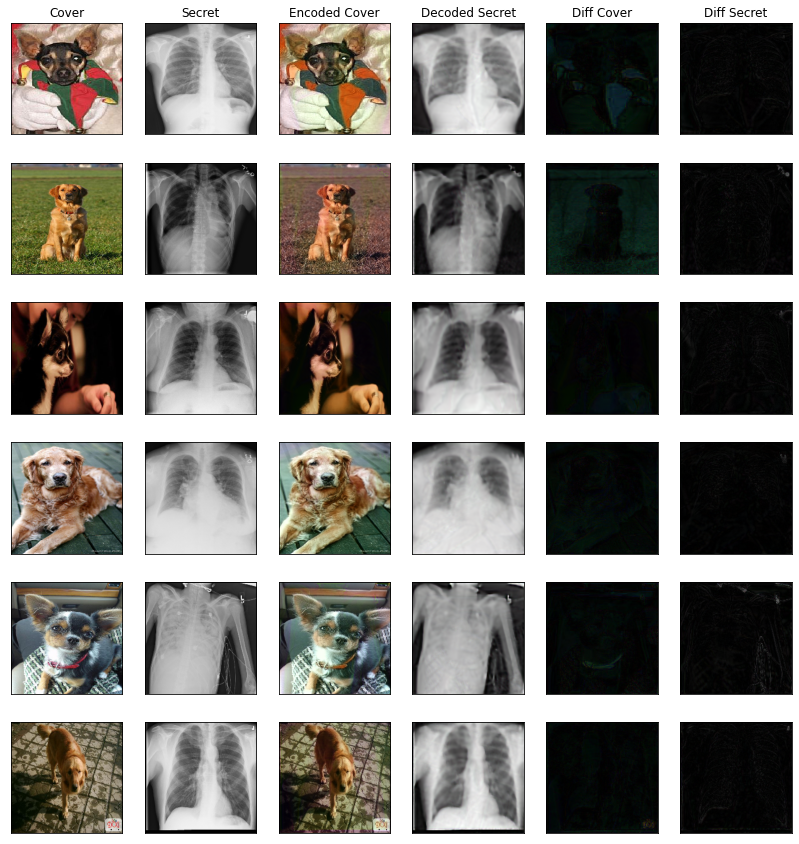

In [ ]:
decoded = autoencoder_model2.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 300) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

# Results

<a id="results"></a>

Although accuracy tends to be the most common performance metric for classifiers, the class imbalance present in our dataset can cause it to be misleading. For example, when dealing with an unbalanced dataset a model that predicts the majority class every time will likely achieve a fairly high accuracy. Additionally, given the context of our data, accuracy may not be preferred metric. Within the medical field it is critically important that when a person has a disease the model correctly predicts the presence of said disease. If not, the consequences can be quite severe, as ill patients can go without receiving the proper treatment as a result.

Given this information, we rely on a few other metrics to report our results, specifically ROC and AUC. A ROC (receiver operating characteristic) curve is a graph that displays the true positive rate versus the false positive rate of a classifier at various thresholds. As mentioned in the previous paragraph, a high true positive rate is desirable within the medical field. AUC (area under the ROC curve) measures the two-dimensional area underneath the entire ROC curve. This provides an aggregate measure of performance across all classification thresholds [9]. In the following section, we outline the results of our modeling in the form of ROC curves and AUC scores for the classification of each disease.

---

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
IMAGE_DIR = 'gdrive/MyDrive/209_project/images'

# Loop through all diagnosis labels and store false and true positive rates
fpr_list = []
tpr_list = []


for i in range(len(labels)):  
  valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image", str(labels[i]));
  model = tf.keras.models.load_model('gdrive/MyDrive/209_project/' + str(labels[i]));
  preds = model.predict(test_generator);
  fpr, tpr, thresholds = roc_curve(test_generator.labels, preds);
  fpr_list.append(fpr)
  tpr_list.append(tpr)


Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image fil

In [35]:
sorted_names = ['r', 'b', 'g', 'k', 'c', 'm', 'y']

#### Non-weighted model

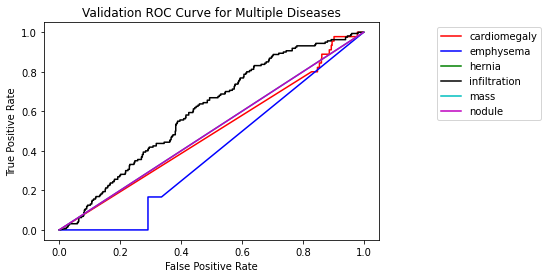

In [ ]:
plt.figure()
for i in range(6):
    plt.plot(fpr_list[i],tpr_list[i],sorted_names[i], label  = f'{labels[i]}')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.title('Validation ROC Curve for Multiple Diseases')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

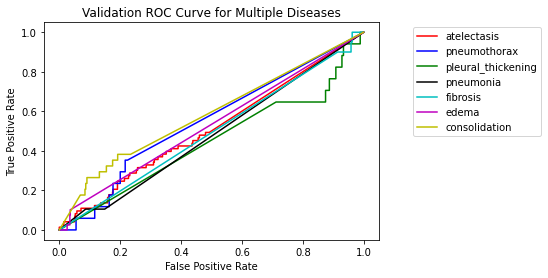

In [ ]:
plt.figure()
for i in range(7):
    plt.plot(fpr_list[i+6],tpr_list[i+6],sorted_names[i], label  = f'{labels[i+6]}')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.title('Validation ROC Curve for Multiple Diseases')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [34]:
import warnings
warnings.filterwarnings('ignore')

# Loop through all diagnosis labels and store false and true positive rates
fpr_list_weights = []
tpr_list_weights = []

for i in range(len(labels)):  
  #train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", str(labels[i]));
  valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "Image", str(labels[i]));
  model = tf.keras.models.load_model('gdrive/MyDrive/209_project/' +str(labels[i])+ 'weights');
  preds = model.predict(test_generator);
  fpr, tpr, thresholds = roc_curve(test_generator.labels, preds);
  fpr_list_weights.append(fpr)
  tpr_list_weights.append(tpr)

Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image filenames.
Found 3361 validated image filenames.
Found 822 validated image filenames.
Found 816 validated image fil

#### Weighted model

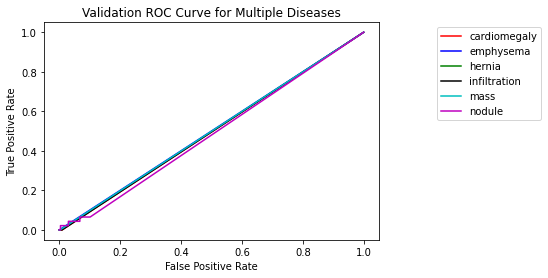

In [37]:
plt.figure()
for i in range(6):
    plt.plot(fpr_list_weights[i],tpr_list_weights[i],sorted_names[i], label  = f'{labels[i]}')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.title('Validation ROC Curve for Multiple Diseases')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

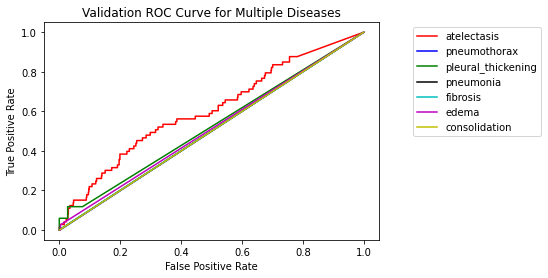

In [43]:
plt.figure()
for i in range(7):
    plt.plot(fpr_list_weights[i+6],tpr_list_weights[i+6],sorted_names[i], label  = f'{labels[i+6]}')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.title('Validation ROC Curve for Multiple Diseases')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As shown by the plots above, our non-weighted model is only able to add prediction value to some of the diseases and our weighted model is only able to add prediction value for one disease. Specifically, our models gives good predictions for infiltration, consolidation, pneumothorax and atelectasis. The other diseases have very low AUC scores showing that our model does not perform much better than a baseline model.

<a id="discussion"></a>

# Discussion

Overall, based on the results included in the previous section, model three (EfficientNet-B0) appears to be the best chest X-ray image classifier. Perhaps this model architecuture is better suited for the classification of X-ray images than DenseNet. Note that we also trained model three on augmented data, which may contribute to its increased performance as well. 

The plots in the results section show which diseases can easily be predicted using CNNs versus which ones cannot. As is, this network could not be used to diagnose diseases. However, with more time we would recommend fine-tuning the models for infiltration, consolidation, pneumothorax and atelectasis as the plots for these features show high potential for predictive ability.

Despite the fairly reasonable results provided in the previous sections, our project suffers from a few limitations. First, due to the time constraints of the project and limited computational power on each of our devices, we were only able to train our models on a limited number of X-ray images and for a limited number of epochs. Ideally, we would train our models on larger portion of the full dataset for a greater number of epochs, yet this is not feasible. Second, again due to limited computational power on each of our devices and time constraints, we were forced to downsize the images in the dataset. Perhaps the models would perform better if trained on the higher resolution images that were initially provided.

Given the limitations outlined above, our project provides a few opportunities for future work. As suggested in the previous paragraph, our models are likely to achieve better performance if trained on a greater quantity of high resolution X-ray images for a greater number of epochs. We also recommend exploring the fine-tuning of other popular CNN architectures such as InceptionV3, AlexNet, and VGG [10]. Ideally, one would compare performance across all of these various architectures. 

---

<a id="ref"></a>

# References

[1] Igor Kononenko. “Machine Learning for Medical Diagnosis: History, State of the Art and Perspective”. In: *Artificial Intelligence in Medicine* 23.1 (2001), pp. 89–109.

[2] Xiaosong Wang et al. “Chestx-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases”. In: *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*. (2017), pp. 2097–2106.

[3] Mikołajczyk, A., & Grochowski, M. "Data Augmentation for Improving Deep Learning in Image Classification Problem." In: *2018 International Interdisciplinary PhD Workshop (IIPhDW)*. (2018), pp. 117-122.

[4] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. "Densely Connected Convolutional Networks." In: *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*. (2017), pp. 4700-4708.

[5] Singhal, Gaurav. "Introduction to DenseNet with TensorFlow." In: *Plural Insights*. (2020).

[6] Tan, M., & Le, Q. "Efficientnet: Rethinking Model Scaling for Convolutional Neural Networks." In: *International Conference on Machine Learning*. (2019), pp. 6105-6114.

[7] Tan, M., & Le, Q. "EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling." In: *Google AI Blog*. (2019).

[8] Baluja, S. "Hiding images in plain sight: Deep steganography." *Advances in neural information processing systems* (2017).

[9] "Classification: ROC Curve and AUC." In: *Google AI Blog*. (2020).

[10] Satya Mallick. “Transfer Learning for Medical Images”. In: *LearnOpenCV* (2021). 4